# Multi-Arm Bandit Algorithm

## References
1. *Practical Statistics for Data Scientists: 50 Essential Concepts* by Peter Bruce, Andrew Bruce
1. https://en.wikipedia.org/wiki/Multi-armed_bandit

## Problem statement
**Multi-arm bandit**
An imaginary slot machine with multiple arms for the customer to choose from, each with different payoffs, here taken to be an analogy for a multitreatment experiment.

Algorithm is popular A/B testing.

Each arm has an unknown probability of win or, in general, expected payoff.
You have only limited number of tries.
Your goal is to maximize the payoff.

## Exploration vs. Exploitation

Exploration: you spend the first several rounds randomly selecting "arms", then pick the best one and use only that one. But you potentially wasted these rounds by not choosing the best earlier.

Exploitation: you try to figure out quickly which is the best arm and use only it. But you may have picked the wrong one. In that case you should have spent more time exploring.

## Bandit algorithms

Hybrid approach. Keep exploring, but give preference the "arm" with the best results at that moment.

### Epsilon-greedy algorithm

1. Generate a random number between 0 and 1. 
1. If the number lies between 0 and epsilon (where epsilon is a number between 0 and 1, typically fairly small), pick the "arm" at random
3. If the number is ≥ epsilon, show whichever offer has had the highest reward to date.




### Thompson Sampling

After each step we reevaluate expected reward for each "arm", then pick the "arm" with the best expected reward. For example, suppose you can win `$1`, `$5` or `$10`. Then if the respective probabilities are $p_1$, $p_5$ and $p_10$, the expected reward is:

$$ E[reward] = p_1 + 5 p_5 + 10 p_10 $$

Now, rather than use the point estimates of the probabilities $p_i$, we take a sample from the posterior distribution. 

Just to remind you the Bayes rule:

$$ p(A|B) = \frac{p(B|A) p(A)}{p(B)} $$

The probabilities of the rewards follow the Multinomial distribution (or Binomial distribution in case we can have only a reward of fixed value). The probability that we receive reward #1 $n_1$ times, reward #2 $n_2$ times, etc. is:

$$ p(n_1 ... n_k) = \frac{n!}{n_1! ... n_k!} q_1^{n_1} ... q_k^{n_k}$$

Here  $\sum_{i=1}^k{ q_i }= 1$.

The prior distribution of the parameters $q$ is Dirichlet distribution:

$$ p(q) = \frac{1}{B(\alpha)}  \prod_{i=1}^k {q_i^{\alpha_i-1}} $$

Since we don't know anything about the multi-armed bandit until we started interacting with it, it makes sense to set all $\alpha$ to the same value, for example, to 1.

Since the Dirichlet distribution is a conjugate prior of the Multinomial distribution, the posterior distribution is also Dirichlet distribution with parameters $\alpha_i = n_i$






So the algorithm is as follows:
1. For each arm recalculate the parameters of the posterior distribution
2. For each arm draw a sample from the posterior distribution
3. For each arm calculate the expected reward
3. Pick the arm that has the highest expected reward

As the parameters of the posterior distribution increase, the distribution becomes more and more narrow, and the exploration elements naturally decreases in favor of the exploitation.

In our examples we will use a fixed reward, so instead of Multinomial distribution we will be using Binomial distribution, and instead of Dirichlet distribution we will use beta distribution. 

## Naive approach

In [1]:
import random
def draw(p):
    return 1 if random.random() <= p else 0

In [2]:
random.seed(6)
p_a = 0.5
p_b = 0.51

First we illustrate that the naive approach "exploration first, exploitation second" can be not optimal, especially when the data generating processes are close.

In [3]:
for i in range(10):
    print('A:',draw(p_a), 'B:', draw(p_b))    

A: 0 B: 0
A: 1 B: 1
A: 1 B: 0
A: 1 B: 0
A: 1 B: 0
A: 1 B: 0
A: 0 B: 1
A: 0 B: 0
A: 1 B: 0
A: 0 B: 1


As you see, even though the probability of the second arm is higher, for the first 10 trials we got better reward for a weaker arm.


Next we will try epsilon-greedy strategy, and will try to see what is the best value of the epsilon.

## Epsilon-greedy algorithm

In [5]:
class Arm(object):
  successes = 0
  failures = 0
  
  def __init__(self, p):
    self.p = p
  
  def prob(self):
    if self.successes + self.failures == 0:
      return 0.5
    else:
      return self.successes / (self.successes + self.failures)
    
  def add_success(self):
    self.successes += 1
    
  def add_failure(self):
    self.failures += 1
    
  def attempts(self):
    return self.successes + self.failures
   
  
  
def epsilon_greedy(p_a, p_b, epsilon, max_attempts):
    a = Arm(p_a)
    b = Arm(p_b)
    
    for _ in range(max_attempts):
      if draw(epsilon) or a.prob() == b.prob():
        selected = random.choices((a, b))[0]
      else:
        selected = a if a.prob() > b.prob() else b
    
      if draw(selected.p):
        selected.add_success()
      else:
        selected.add_failure()
    
    return a.successes + b.successes, a.attempts() ,b.attempts()

In [6]:
p_a = 0.5
p_b = 0.6
random.seed(5)
print(epsilon_greedy(p_a, p_b, 0, 1000))

(519, 999, 1)


Not great. But look, since the epsilon is zero, it sticks to its first choice, which in our case is the worse arm. Let's try to increase epsilon to see if we can get better results

In [7]:
random.seed(5)
print(epsilon_greedy(p_a, p_b, 0.3, 1000))

(583, 277, 723)


This is better! Not only we've got more money, but we also have the algorithm prefer the second arm. This means that the algorithm has learned which arm is better. Let's see the results we get for different values of epsilon:

In [8]:
import numpy as np
import pandas as pd
from statistics import mean
eps = []
results = []
for epsilon in np.linspace(start=0.0, stop=1.0, num=40):
  attempts = []
  for seed in range(100):
    random.seed(seed)
    attempts.append(epsilon_greedy(p_a, p_b, epsilon, 1000)[0])
  eps.append(epsilon)
  results.append(mean(attempts))

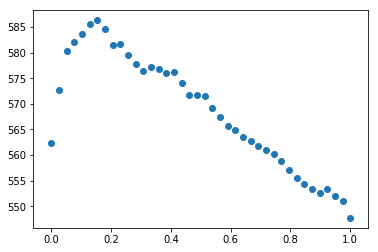

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.scatter(x=eps, y=results);

This seems like the performance generally worsen as epsilon increases. Let's try to see the best value of $\epsilon$

In [10]:
best_epsilon = eps[np.argmax(results)]
best_epsilon

0.15384615384615385

And the best average reward is:

In [11]:
best_reward = np.max(results)
best_reward

586.28

## Thompson sampling. 

Since each arm has a fixed reward, its distribution can be modeled as Bernoulli distribution, and the corresponding conjugate prior is Beta distribution. It has two parameters $\alpha$ and $\beta$:

$$P(q) = \frac{q^{\alpha-1}(1-q)^{\beta-1}}{B(\alpha,\beta)} $$

The uninformative prior corresponds to both $\alpha$ and $\beta$ equals to 1. The parameters of the posterior distribution are updated using this simple rule:

$$\alpha = \alpha +\textrm{number of successes}$$
$$\beta = \beta + \textrm{number of failures}$$


In [12]:
class ThompsonArm(Arm):
  init_alpha = 1
  init_beta = 1
  
  def sample(self):
    alpha = self.init_alpha + self.successes
    beta = self.init_beta + self.failures
    return np.random.beta(alpha, beta)
  
def thompson(p_a, p_b, max_attempts):
    a = ThompsonArm(p_a)
    b = ThompsonArm(p_b)
    
    for _ in range(max_attempts):
      a_sample = a.sample()
      b_sample = b.sample()
      if a_sample == b_sample:
        selected = random.choices((a, b))[0]
      else:
        selected = a if a_sample > b_sample else b
    
      if draw(selected.p):
        selected.add_success()
      else:
        selected.add_failure()
    
    return a.successes + b.successes, a.attempts() ,b.attempts()

In [13]:
thompson(p_a, p_b, 1000)

(603, 191, 809)

We can see that it favors heavily the second arm. Let's run it multiple time and see what would be the average reward

In [14]:
for seed in range(1000):
    random.seed(seed)
    np.random.seed(seed)
    attempts.append(thompson(p_a, p_b, 1000)[0])
print(np.mean(attempts))                   

584.7009090909091


It is almost exactly the same as for the best reward of the epsilon-greedy algorithm, but the difference here is that we don't need to do hyperparameter tuning. Thompson sampling will almost always perform better than epsilon-greedy approach, when we don't have a luxury to try different values of $\epsilon$

## Further research

**Contextual bandit** algorithm is when you also have an input vector X as an additional help in making the right selection. Many algorithms exist in training the model, starting from linear models and going all the way up to multilayer neural networks.